In [1]:
!echo "Last updated: `date`"

Last updated: Wed Aug  5 22:10:58 PDT 2020


## Process Convolution ([Higdon 2002][1])

$$
\begin{eqnarray}
y_n \mid p_i &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(p_i) &:=& \mathbf{K_{\rho}} \cdot \mathbf{z} \\
z_m \mid \alpha &\sim& \text{Normal}(0, \alpha), \text{ for } m=1,\dots, M \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
%
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\p}[1]{\left(#1\right)}
$$


Note: 
- The latent GP should be centered at 0, because when there is no data, $P(y_i = 1)$ should be $0.5$.
- $M$ is the number of knots, and should be substantially smaller than $N$ for speedups for vanilla GP.
- $\mathbf{z}$ are realizations from a (continuous) white noise process.
- $K_{n,m} = \exp\p{-\frac{\norm{\mathbf{x}_n - \mathbf{w}_m}^2_2}{\rho^2}}$.
  This implies a squared exponential covariance function. $\rho$ resembles the range parameter.
  Note that $K$ is $N\times M$ and is called a smoothing kernel.
- $\mathbf{x}_n$ are observed (possibly multivariate) spatial locations.
- $\mathbf{w}_m$ are user-specified knot locations of same dimensions as $\mathbf{x}_i$.
- Convolving the smoothing kernel with a white noise process yields a GP.

***

**References**
1. Higdon, Dave. "Space and space-time modeling using process convolutions." Quantitative methods for current environmental issues. Springer, London, 2002. 37-56.

[1]: https://link.springer.com/content/pdf/10.1007%2F978-1-4471-0657-9_2.pdf

In [2]:
# Load libraries.
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import pystan
import sys
sys.path.append('../util')
from distance import euclidean
from tqdm import trange

*** 
Below are some helpers for plotting and generating data / grids.

In [3]:
def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

In [4]:
def plot_data(X, y, edgecolors=None):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y], edgecolors=edgecolors)

In [5]:
def make_gp_predict(X, W, n_new=1000, eps=0):
    n_grid = int(np.floor(np.sqrt(n_new)))
    X_new, x0, x1 = gen_grid(X, n_grid, return_each=True, eps=eps)
    n_new = X_new.shape[0]
    Dsq = np.power(euclidean(X_new, W), 2)
    
    def gp_predict(z, rho):
        K = np.exp(-Dsq/(rho*rho))
        return K.dot(z)
    
    return gp_predict, X_new, x0, x1

sigmoid = lambda x: 1 / (1 + np.exp(-x))

def plot_knots(W, color='grey', **kwargs):
    plt.scatter(W[:, 0], W[:, 1], color=color, marker='x', **kwargs)

In [6]:
# Data dictionary.
def create_stan_data(X, y, M, m_rho=0, s_rho=1, m_alpha=0, s_alpha=1, eps=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    N, P = X.shape
    assert (N, ) == y.shape
    
    ngrid = int(np.floor(np.sqrt(M)))
    W = gen_grid(X, n=ngrid, eps=eps)
    M = W.shape[0]
    
    return dict(y=y, X=X, M=M, N=N, P=P, W=W,
                m_rho=m_rho, s_rho=s_rho,
                m_alpha=m_alpha, s_alpha=s_alpha)

In [18]:
def plot_uq(post_samples, X, y, W, algo, n_new=1000, eps=0.2, figsize=(10, 8),
            color_res=100, return_stuff=False, data_edgecolors=None):
    nsamples = post_samples['z'].shape[0]
    
    gp_predict, X_new, x0, x1 = make_gp_predict(X, W, eps=eps, n_new=n_new)
    
    preds = np.stack([gp_predict(post_samples['z'][i, :],
                                 post_samples['rho'][i])
                      for i in trange(nsamples)]) 
    
    plt.figure(figsize=figsize)
    
    # Plot mean function.
    plt.subplot(2, 2, 1)
    plt.contourf(x0, x1, sigmoid(preds).mean(0).reshape(x0.shape),
                 color_res,
                 cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.colorbar();
    plot_knots(W, color='black')
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ({})".format(algo))
    
    # Plot function sd.
    plt.subplot(2, 2, 2)
    plt.contourf(x0, x1, sigmoid(preds).std(0).reshape(x0.shape),
                 color_res, cmap=plt.get_cmap('Oranges'))
    plt.colorbar();
    plot_knots(W, color='black')
    # plt.scatter(X[:, 0], X[:, 1], color='grey'); 
    plot_data(X, y)
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior Standard Deviation Function ({})".format(algo))
    
    # Plot histogram of rho.
    plt.subplot(2, 2, 3)
    plt.hist(post_samples['rho'], bins=30, density=True);
    plt.title(r"Histogram of $\rho$ ({})".format(algo));
    plt.xlabel(r"$\rho$");
    plt.ylabel("density");
    
    plt.subplot(2, 2, 4)
    plt.hist(post_samples['alpha'], bins=30, density=True);
    plt.title(r"Histogram of $\alpha$ ({})".format(algo));
    plt.xlabel(r"$\alpha$");
    plt.ylabel("density");
    
    if return_stuff:
        return X_new, preds

***

In [8]:
# Set random seed for reproducibility.
np.random.seed(1)

In [9]:
# Process convolution model.
model_code = """
data {
  int<lower=0> N;
  int<lower=0> M;
  int<lower=0> P;
  int<lower=0, upper=1> y[N];
  matrix[N, P] X;
  matrix[M, P] W;
  real m_rho;
  real<lower=0> s_rho;
  real m_alpha;
  real<lower=0> s_alpha;}

transformed data {
  matrix[N, M] Dsq;  // Squared distance matrix.

  // Create distance matrix.
  for (n in 1:N) for (m in 1:M) {
    Dsq[n, m] = distance(X[n, :], W[m, :])^2;
  }
}

parameters {
  vector[M] z;  // White noise process.
  real<lower=0> rho;  // Range parameter in covariance.
  real<lower=0> alpha;  // amplitude parameter in covariance.
}

model {
  matrix[N, M] K;  // Kernel matrix.

  // Priors.
  rho ~ lognormal(m_rho, s_rho);
  alpha ~ lognormal(m_alpha, s_alpha);
  z ~ normal(0, alpha);

  // Populate kernel matrix.
  for (n in 1:N) for (m in 1:M) {
    K[n, m] = exp(-Dsq[n, m] / (rho^2));
  }
  
  // Model.
  y ~ bernoulli_logit(K * z);
}
"""

In [10]:
# Compile model. This takes about a minute.
%time sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5558275772586b0064a027212290bc4b NOW.


CPU times: user 835 ms, sys: 51.6 ms, total: 886 ms
Wall time: 48.7 s


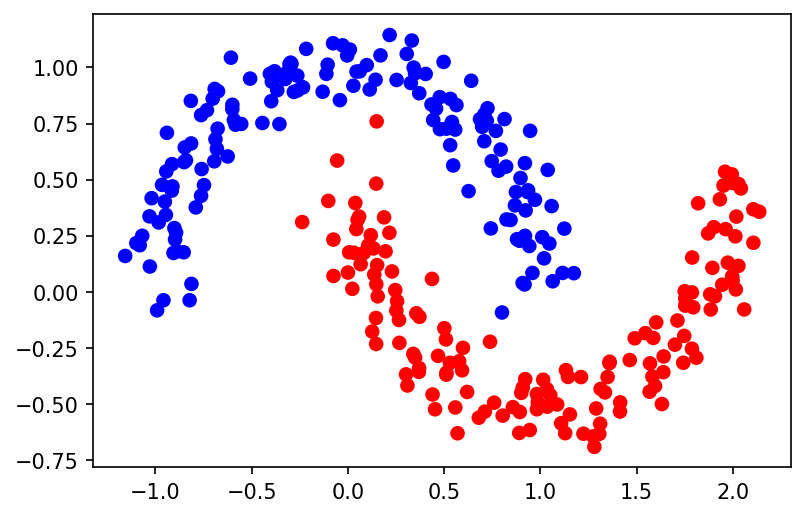

In [11]:
# Read data.
path_to_data = '../data/gp-binary-data-N300.json'
simdata = json.load(open(path_to_data))

# Store data.
X = np.stack([simdata['x1'], simdata['x2']], axis=-1)
y = np.array(simdata['y'])

# Plot data.
plot_data(X, y)

In [12]:
# Generate stan data dictionary.
stan_data = create_stan_data(X, y, M=100, seed=1, eps=0.1, s_alpha=0.1)

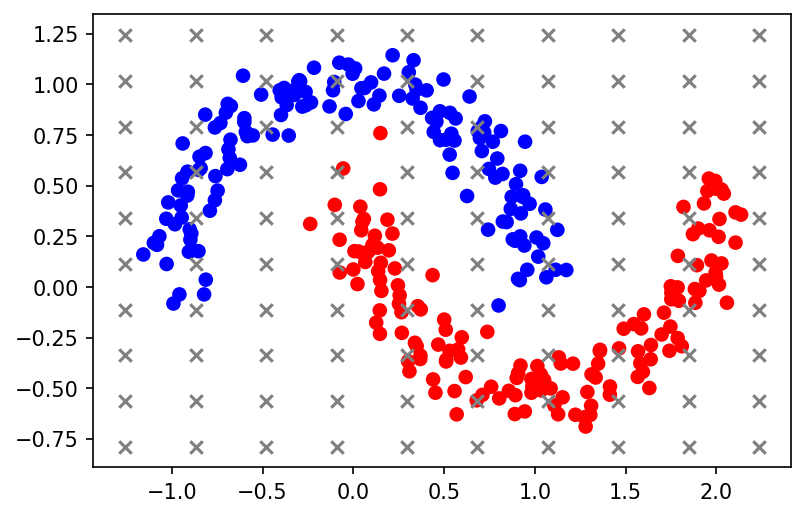

In [13]:
# Plot data with knots.
plot_data(X, y)
plt.scatter(stan_data['W'][:, 0], stan_data['W'][:, 1], color='grey', marker='x');

In [14]:
%%time
# Fit via HMC
hmc_fit = sm.sampling(data=stan_data, iter=1000, chains=1, warmup=500, thin=1,
                      seed=1, algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

CPU times: user 24.1 s, sys: 21 ms, total: 24.1 s
Wall time: 24 s


In [15]:
%%time
# Fit via NUTS
nuts_fit = sm.sampling(data=stan_data, iter=1000, chains=1, warmup=500, thin=1, seed=1)

CPU times: user 1min 6s, sys: 105 ms, total: 1min 6s
Wall time: 1min 5s


100%|██████████| 500/500 [00:01<00:00, 447.26it/s]


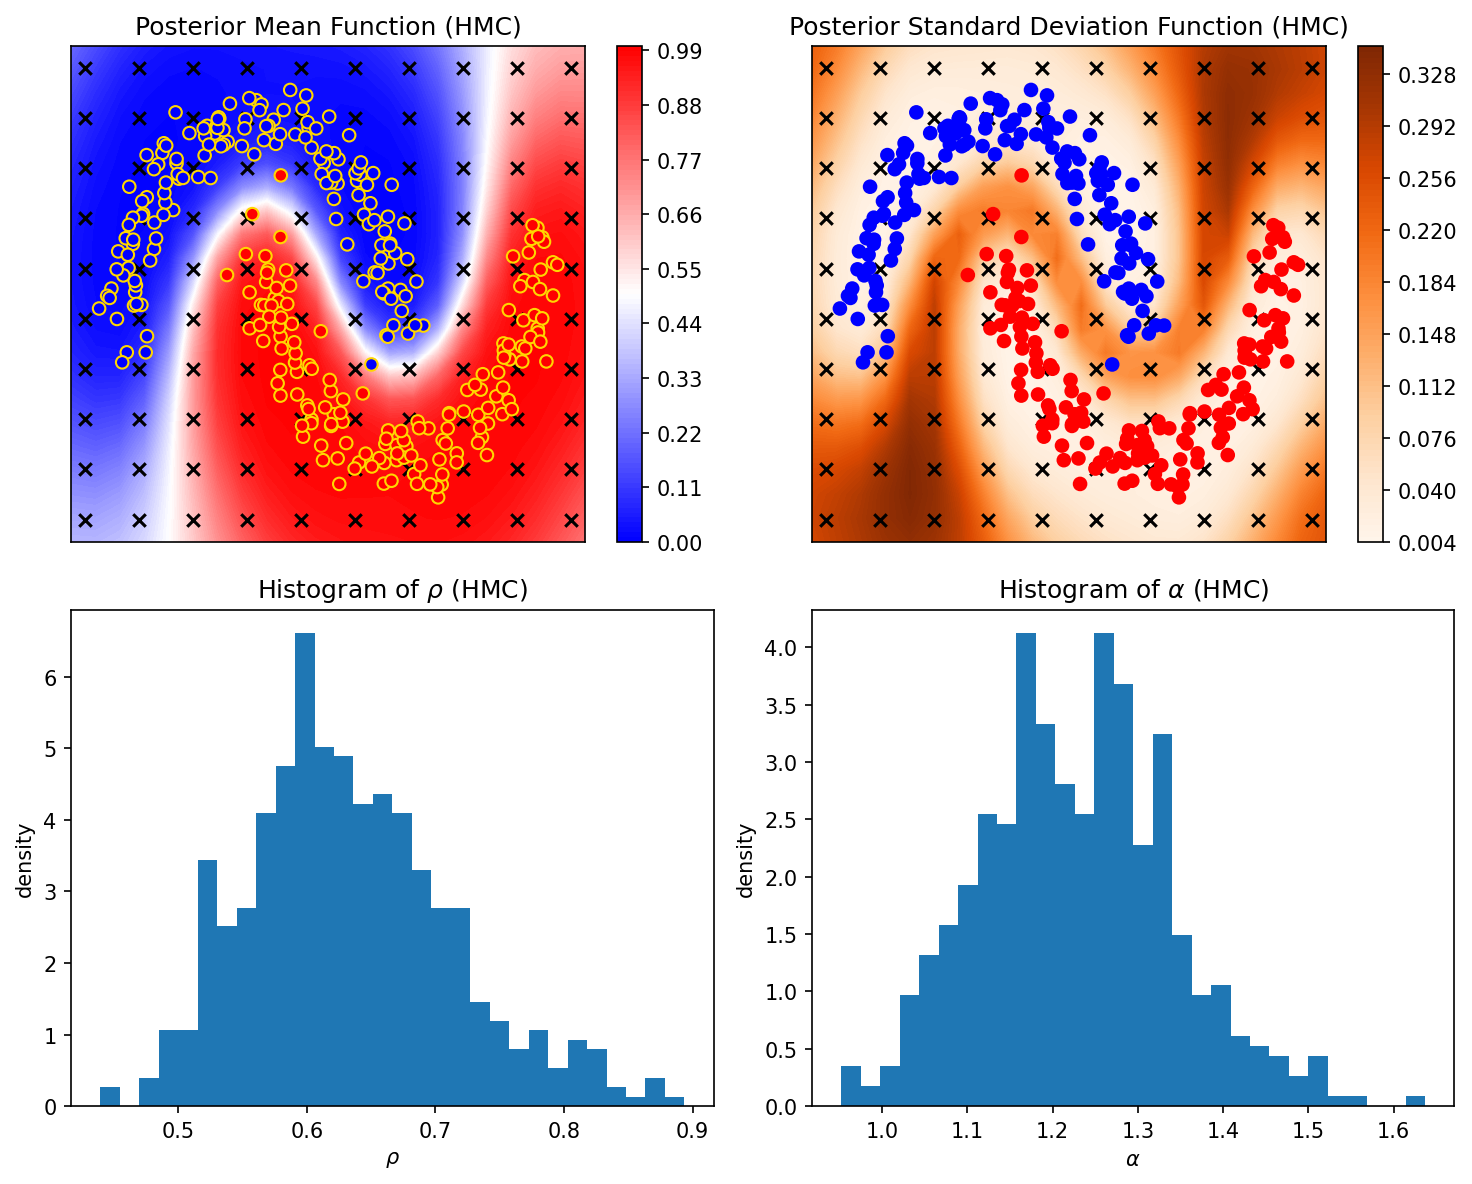

In [27]:
plot_uq(hmc_fit, X, y, stan_data['W'], 'HMC', n_new=500, data_edgecolors='gold')
plt.tight_layout()

100%|██████████| 500/500 [00:01<00:00, 456.33it/s]


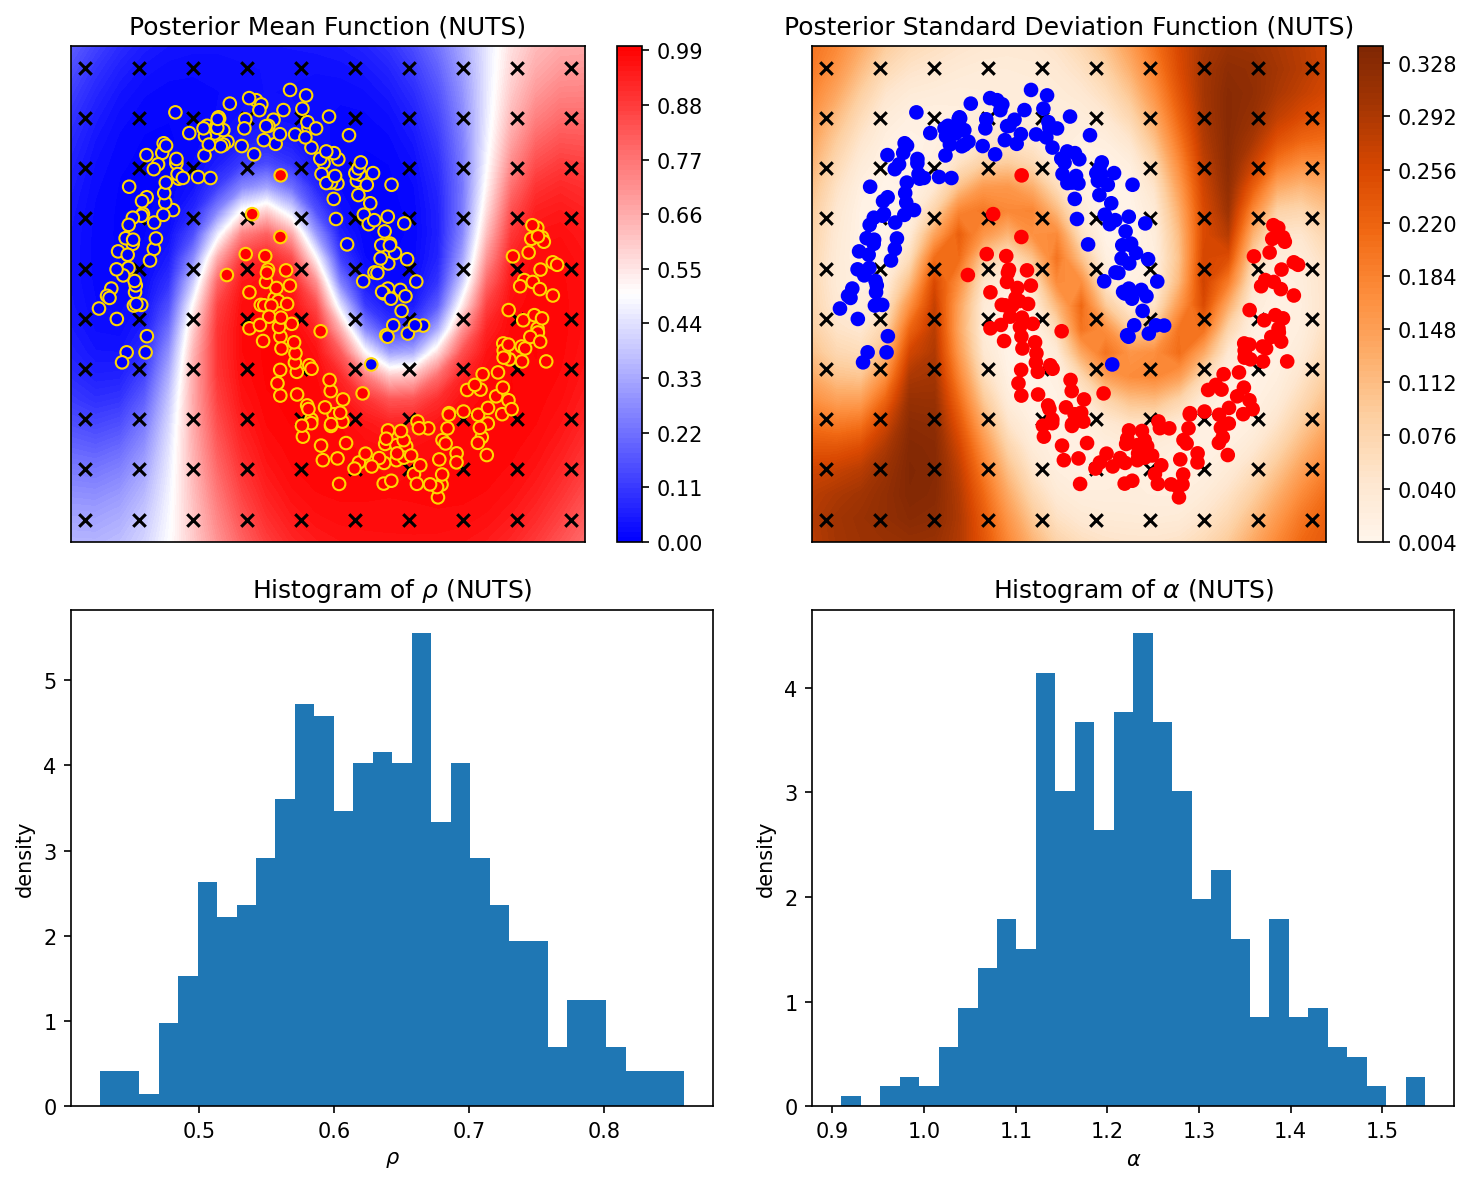

In [20]:
plot_uq(nuts_fit, X, y, stan_data['W'], 'NUTS', n_new=500, data_edgecolors='gold')
plt.tight_layout()